# Lab 6 - Diffusion models

Diffusion models can generate beautiful images, but they have also generated a lot of hype in the realm of generative methods in the recent two years. Today, we will learn what is under their hood and implement them.

Plan for today:
* implement a [Denoising Diffusion Model](https://arxiv.org/abs/2006.11239)
* turn it into a [Conditional one](https://arxiv.org/abs/2207.12598)

In [1]:
import torch
from torch.optim import SGD, Adam
from torch import nn
import torch
from typing import List
from torchvision.datasets import MNIST
from torchvision import transforms as tv
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from time import sleep
from torchvision.models import vgg16, vgg16_bn, resnet50, resnet18

from collections import Counter
from typing import Tuple

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
ds_train = MNIST(root="data", train=True, download=True, transform=tv.Compose(
        [tv.Resize(64), tv.ToTensor()]
    ))

ds_test = MNIST(root="data", train=False, download=True, transform=tv.Compose(
       [tv.Resize(64), tv.ToTensor()]
    ))

batch_size=128
dl_train = DataLoader(ds_train, batch_size, shuffle=True, drop_last=False) # dataloader with full dataset 

dl_test = DataLoader(ds_test, batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 87539607.96it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30336449.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18993548.12it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# 1 - Denoisng diffusion


The denoising diffusion models generate images from random noise by iteratively de-noising them. Thus, we need to train a model which can remove small portions of noise from images:

![diffusion](https://cvpr2022-tutorial-diffusion-models.github.io/img/diffusion.png)

**Let us recap the diffusion models from the lecture:**

**1.** In image $x_0$ is *diffused* by adding random noise. This process is repeated and we construct progressively more noisy images: $x_1, x_2, ..., x_T$, where $T$ is a fixed number of steps (e.g. 1000).

**2.** The denoising process is designed such that after $T$ steps $x_T \sim \mathcal{N}(0, I)$.

**3.** The diffusion process is ususally not constant across time - we define a **schedule** of $\beta_t$, which denotes the variance of the noise sampled at each step. Ususally, $\beta_t$ increases with $t$.

**4.** The value of each $x_t$ depends solely in $x_{t-1}$ and the noise sampled at step $t$. $x_t$ is sampled from conditional distribution: $$x_t \sim \mathcal{N}(\sqrt{1 - \beta_t}x_{t-1}, \beta_t I)$$

Thus: $$x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} \epsilon_{t-1} $$

Where $\alpha_t = 1 - \beta_t$ and $\epsilon_t \sim \mathcal{N}(0, I)$ is the noise sampled during step $t$.

### Task 1 - implement naive noising process:
For an image batch, please sample the noise $t$ times and return noised image. Visualize the noised images:

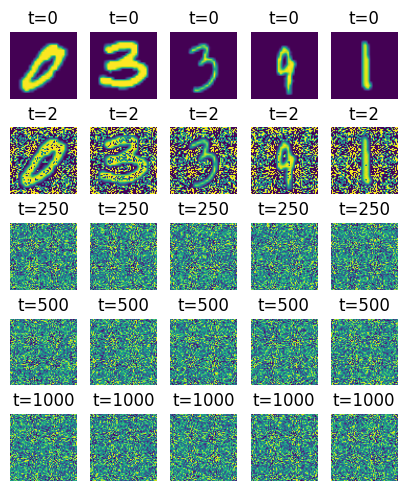

In [4]:
def naive_noise(x, t, b0=1e-4, bT=0.02, T=1000):
    """
    Iterative image noising
    x: images batch (B, C, H, W)
    t: timesteps (B) - note that t can be different for each imagei n the batch!
    b0, bT, T: schedule parameters - b increases uniformly between b0 and bT between steps 0 and T (maximal step).
    
    Returns:
        A tensor of the same shape as x, appropriately noised
    """
    for i in range(1, t+1):
      epsilon = torch.randn(x.size(0), x.size(1), x.size(2), x.size(3))
      alfa = torch.tensor(1-b0-(bT-b0)*i/T)
      x = torch.sqrt(alfa)*x + torch.sqrt(1-alfa)*epsilon

    return x
    

for X, _ in dl_train:
    break
    
X = X[:5]
X_noised = {t: naive_noise(X, t) for t in [0, 2, 250, 500, 1000]}

fig, ax = plt.subplots(ncols=len(X), nrows=len(X_noised), figsize=(len(X),len(X_noised)+1 ))

for i, (t, Xs) in enumerate(X_noised.items()):
    for j, x in enumerate(Xs):
        ax[i,j].imshow(F.to_pil_image(x))
        ax[i,j].axis("off")
        ax[i,j].set_title(f"{t=}")




**5.** Do we need to perform sampling $t$ times to obtain $x_t$? We can do it more effectively:

We can calculate the parameters of distribution $p(x_t | x_0)$: $$x_t \sim \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1 - \bar{\alpha}_t)I)$$

And sample from this distribution with a single noise sample $\epsilon$: 

$$x_t =  \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon$$

Where $\bar{\alpha}_t = \prod^t_{i=1} \alpha_i$ (cumulative product).

### Task 2 - implement an efficient sampling function

For an image batch, sample a noised version at step $t$ from distribution described above.

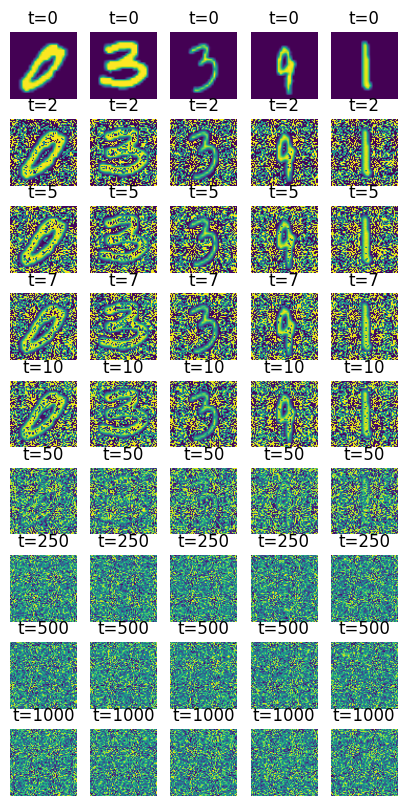

In [5]:
def single_noise(x, t, b0=1e-4, bT=0.02, T=1000):
    """
    x: images batch (B, C, H, W)
    t: timesteps (B)
    b0, bT, T: schedule parameters - b increases uniformly between b0 and bT between steps 0 and T (maximal step).
    
    Returns:
        * A tensor of the same shape as x, appropriately noised
        * epsilon - noise tensor of the same shape as x

    """

    alfas = torch.zeros(t+1)
    alfas[0] = 1
    for i in range(1, t+1):
      alfas[i] = 1-b0-(bT-b0)*i/T
    alfas_prod = torch.prod(alfas)

    epsilon = torch.randn(x.size(0), x.size(1), x.size(2), x.size(3))

    x=x.to(device)
    alfas_prod = alfas_prod.to(device)
    epsilon = epsilon.to(device)


    x = torch.sqrt(alfas_prod)*x + torch.sqrt(1-alfas_prod)*epsilon
    
    epsilon = epsilon.to(device)

    return x, epsilon
    
 
X_noised = {
    t: single_noise(X, t)[0] # we do not care about epsilon yet 
    for t in [0, 2, 5, 7, 10, 50, 250, 500, 1000]
}

fig, ax = plt.subplots(ncols=len(X), nrows=len(X_noised), figsize=(len(X),len(X_noised)+1 ))

for i, (t, Xs) in enumerate(X_noised.items()):
    for j, x in enumerate(Xs):
        ax[i,j].imshow(F.to_pil_image(x))
        ax[i,j].axis("off")
        ax[i,j].set_title(f"{t=}")



**6.** Our model, $\epsilon_\theta$ must predict the parameters of distribution: $p(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$

For simplicity, let variance be non-trainable: $ \Sigma_\theta(x_t,t) = \beta_t I$. Thus, our model must only predict the means of the distribution. 

Let's simplify things even more - if our model can correctly predict the **noise** used to construct $x_t$, then we can calculate $\mu_\theta(x_t,t)$ from it:

$$\mu_\theta(x_t,t)  = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t)) $$

**7.** Thus, the loss function will be given by: $$\mathcal{L}(x_0, t, \epsilon)  = || \epsilon - \epsilon_\theta(x_t, t)||$$

Where $x_t =  \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon$

**8.** To sum it up, our model needs to predict the noise value $\epsilon$ based on an image $x_t$. From that, we can calculate the mean of distribution (variance is constant for a given $t$) and sample $x_{t-1} \sim \mathcal{N}(\mu_\theta(x_t,t), \beta_t I)$. It we do it $t$ times, we should arrive at a **denoised** image.

### What kind of model do we need?

For the model to predict noise of the data, it needs to be $\mathbb{R}^n \rightarrow \mathbb{R}^n$ - same dimensionality of input and output. In practice, a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)-like architecture works well:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=500></img>

### Task 3 - implement a U-Net-like net for MNIST

In [6]:
class Block(nn.Module):
  def __init__(self, in_ch, out_ch, up=False):
    super().__init__()
    if up:
      self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.bnorm = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.bnorm(self.relu(self.conv1(x)))
    x = self.bnorm(self.relu(self.conv2(x)))
    return self.transform(x)

class MNISTUNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1
        # initialize 2-3 downsampling / upsampling blocks

        self.initial_conv = nn.Conv2d(img_channels, down_channels[0], kernel_size=3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1]) for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], up=True) for i in range(len(up_channels)-1)])

        self.final_conv = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x):
        x = self.initial_conv(x)
        
        for down in self.downs:
          x = down(x)
        for up in self.ups:
          x = up(x)
        return self.final_conv(x)

        # forward X through downsampling / upsampling. 
        # skip connections are not 100% necessary for MNIST
        # in the DDPM paper they also use t as positional encoding, but we can also omit it for MNIST

### Task 4 - train a diffusion model
* complete the training loop
* every 10 epochs please visualize the sampling process on a couple of examples

In [7]:
import random

diffusion = MNISTUNet().to(device)
optim = torch.optim.Adam(diffusion.parameters(), lr=2e-4)
loss_fn = torch.nn.MSELoss()

def train_ddpm(
    model, optimizer, 
    num_epochs=100,
    b0=1e-4, bT=0.02, T=500,
    
):

    for e in range(num_epochs):
        print(e, "epoccccccccchhhhhhhhh")
        counter = 0
        for X, _ in dl_train:
            print(counter)
            counter = counter + 1
            optim.zero_grad()

            X = X.to(device)
            
            t = random.randint(0, T)

            X_noise, epsilon = single_noise(X, t, b0=b0, bT=bT, T=T)
            
            # predict the noise with model:

            noise_pred = model(X_noise)
            # calculate the loss (MSE between true and predicted noise):
            loss = loss_fn(epsilon, noise_pred)
            # optimize the model:
            loss.backward()
            optim.step()
        
        # evaluation - let's visualize how our model diffuses images
        
        if e % 10 == 0:
          n_images = 1
          timesteps=[500, 250, 0]

          fig, ax = plt.subplots(
              ncols=1, nrows=len(timesteps),
          )
          current_row = 0

          X = torch.randn(1, X.size(1), X.size(2), X.size(3)).to(device) # sample 5 noise vectors # czy tu X.size() działa poprawnie?
          
          alfas = torch.ones(T+1)
          for i in range(1, T+1):
              alfas[i] = 1-b0-(bT-b0)*i/T
          alfas_prod = torch.prod(alfas)


          for t in range(T, -1, -1):

              print(t, "tttttt")
              pred_noise = model(X)
              variance = torch.tensor(b0 + ((bT- b0) * (t/T))).to(device)
              alfa = torch.tensor(1 - variance)

              pred_mean = (1/torch.sqrt(alfa)*(X - (1-alfa)/torch.sqrt(1-alfas_prod)*pred_noise)).to(device) # calculate the distribution image
              
              alfas_prod = alfas_prod/alfa

              z = torch.randn(X.size(1), X.size(2), X.size(3)).to(device)


              X = (pred_mean + torch.sqrt(variance)*z).to(device)
              
              if t not in timesteps:
                  continue
              i = timesteps.index(t)              
              
              ax[i].imshow(F.to_pil_image(X[0]))
              ax[i].axis("off")
              ax[i].set_title(f"{t=}")

          plt.suptitle(f"{e=}")
          plt.show()
      
  

In [8]:
train_ddpm(diffusion, optim)

0 epoccccccccchhhhhhhhh
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


KeyboardInterrupt: ignored

# 2 - Conditional denoising diffusion


How to convert an uncoditional diffusion model into a [conditional one](https://arxiv.org/pdf/2207.12598.pdf)? It can be done similarly to the way we did it in the last labs in cGAN - by injecting a class vector into the latent. In practice, we can: 
* transform the class label of a sample into a one-hot vector
* process it with a small linear network into a latent $g$
* concatenate $g$ to a hidden representation of our U-Net
    * for example to the bottom-most one; concatenating to multiple hidden representations can work even better.

### Task 5 - modify your UNet architecture to include class conditioning

In [ ]:
class CMNISTUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize 2-3 downsampling / upsampling blocks
    
    def forward(self, X, y):
        ...
        # forward X through downsampling / upsampling. 
        # transform label y into one-hot, process it with a linear layer and add to the hidden representation of X, e.g. between up/down-sampling
        # skip connections are not 100% necessary for MNIST
        # in the DDPM paper they also use t as positional encoding, but we can also omit it for MNIST
    
    


In order to make our model work, we need a couple more tricks that work in practice:

* **Guided / unguided training** - we want our model to be able to estimate *unconditional* diffusion (same as the previous DDPM). This can be done by conditioning it with a vector of zeros instead of one-hots. In practice, we will zero-out a portion of our one-hots with probablility $p$.

* **Sampling through a combination of conditional / unconditional models** - when sampling from model $\epsilon_\theta$, we will repict the noise $\epsilon$ through a linear combination of conditional and unconditional model: $$\epsilon = (1 + w)\epsilon_\theta(x_t, c) - w\epsilon_\theta(x_t, \emptyset)$$ where $w$ is a sampling hyperparameter.

### Task 6 - train a conditional diffusion model


In [ ]:
diffusion = CMNISTUNet(...)
optim = torch.optim.Adam(diffusion.parameters(), lr=2e-4)


def train_cddpm(
    model, optimizer, 
    num_epochs=100,
    num_classes=10,
    unconditional_prob=0.1,
    ws = [0.0, 0.5, 1.0, 2.0],
    b0=1e-4, bT=0.02, T=1000,
    
):
    
    for e in range(num_epochs):
        for X, y in dl_train:
            X = X.to(device)
            y = nn.functional.one_hot(y, num_classes=num_classes).float().to(device)
            
            y = ... # zero-out some elements of y with probability `unconditional_prob` - those will be the unconditional samples
            
            t = ... # sample timestep (t) tensors - ints between 0 and T
            
            X_noise, epsilon = single_noise(X, t, b0=b0, bT=bT, T=T)
            
            # predict the noise with model
            # calculate the loss (MSE between true and predicted noise)
            # optimize the model
        
        # evaluation - let's visualize how our model diffuses images with different ws
        
        # jakiś with torch no grad tu trzeba?

        if e % 20 == 0:
            n_images = 5
            timesteps=[1000, 500, 250, 0]
            
            for w in ws:
                fig, ax = plt.subplots(
                    ncols=len(n_images), nrows=len(timesteps), 
                    figsize=(len(X),len(timesteps)+1)
                )
                current_row = 0

                X = ... # sample 10 noise vectors - each for one class label
                y =  nn.functional.one_hot(
                    torch.tensor(list(range(10))),
                    num_classes=num_classes
                ).float().to(device)

                y_uncond = torch.zeros((10,10)).float().to(device)

                for t in range(T, -1, -1):
                    pred_noise = (1+w)*model(X, y) - w*model(X,y_uncond)
                    pred_mean = ... # calculate the distribution image
                    variance = b0 + ((bT- b0) * (t/T))
                    X = ... # sample new X from distribution parameters
                    if t not in timesteps:
                        continue
                    i = timesteps.index(t)
                    for j, x in enumerate(X):
                        ax[i, j].imshow(F.to_pil_image(x))
                        ax[i, j].axis("off")
                        ax[i, j].set_title(f"{t=}")

                plt.suptitle(f"{e=}, {w=}")
                plt.show()

### Question - how does the value of $w$ influence the model's predictions?
Hint - to answer this, you may want to sample a batch of a few examples of the same class with different $w$'s

## References

Apart from papers, this notebook was based on the following repositories:
* https://github.com/cloneofsimo/minDiffusion
* https://github.com/TeaPearce/Conditional_Diffusion_MNIST
